### This notebook performs burst overlap interferometry (BOI) with CSLC-S1 for two bursts within the San Joaquin Valley, CA for two dates.

Load notebook dependencies.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import os, glob
import h5py
import fsspec
import pandas as pd
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
from shapely import geometry, ops
import xarray as xr
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
import rioxarray
import sys
sys.path.append('../../')
from src.cslc_utils import get_s3path, read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps, moving_window_mean

import warnings
warnings.filterwarnings('ignore')

We will be streaming CSLC-S1 products from S3, which requires the paths in `T144_308014_IW.txt` and `T144_308015_IW.txt`.

In [10]:
data_dir = 's3://opera-pst-rs-pop1/products/CSLC_S1'
burst_id = ['T144_308014_IW2', 
            'T144_308015_IW2']

# get list of dates
b1paths = (open(f"{burst_id[0]}.txt","r").read().split("\n"))
b2paths = (open(f"{burst_id[1]}.txt","r").read().split("\n"))
dates = [path[33:41] for path in b1paths]
nd = len(dates)

# send to dataframe
file_df = pd.DataFrame({'Date':dates,f'{burst_id[0]}':b1paths,f'{burst_id[1]}':b2paths})


Stream from S3 and create inteferogram for each burst.

In [11]:
# burst conjs
b1path1_h5 = file_df[f'{burst_id[0]}'][25][:-1]
b2path1_h5 = file_df[f'{burst_id[1]}'][25][:-1]

b1cslc1 = read_cslc(f'{data_dir}/{b1path1_h5}/{b1path1_h5}.h5')
b2cslc1 = read_cslc(f'{data_dir}/{b2path1_h5}/{b2path1_h5}.h5')

b1path2_h5 = file_df[f'{burst_id[0]}'][26][:-1]
b1cslc2 = read_cslc(f'{data_dir}/{b1path2_h5}/{b1path2_h5}.h5')
b1ifg = b1cslc1*np.conj(b1cslc2)

b2path2_h5 = file_df[f'{burst_id[1]}'][26][:-1]
b2cslc2 = read_cslc(f'{data_dir}/{b2path2_h5}/{b2path2_h5}.h5')
b2ifg = b2cslc1*np.conj(b2cslc2)

Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1_T144-308014-IW2_20161121T135958Z_20230929T092637Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T144-308014-IW2_20161121T135958Z_20230929T092637Z_S1A_VV_v1.0.h5


Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1_T144-308015-IW2_20161121T140001Z_20230929T092637Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T144-308015-IW2_20161121T140001Z_20230929T092637Z_S1A_VV_v1.0.h5
Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1_T144-308014-IW2_20161215T135957Z_20230929T092633Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T144-308014-IW2_20161215T135957Z_20230929T092633Z_S1A_VV_v1.0.h5
Streaming: s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_L2_CSLC-S1_T144-308015-IW2_20161215T140000Z_20230929T092633Z_S1A_VV_v1.0/OPERA_L2_CSLC-S1_T144-308015-IW2_20161215T140000Z_20230929T092633Z_S1A_VV_v1.0.h5


Get shared coordinates between both bursts and crop to burst overlap.

In [12]:
# coordinates of each burst
xcoor1, ycoor1, dx, dy, epsg, bounding_polygon1, orbit_direction = cslc_info(f'{data_dir}/{b1path2_h5}/{b1path2_h5}.h5')
xcoor2, ycoor2, dx, dy, epsg, bounding_polygon2, orbit_direction = cslc_info(f'{data_dir}/{b2path2_h5}/{b2path2_h5}.h5')

# shared coordinates between burtsts
xvalues, xind1, xind2 = np.intersect1d(xcoor1,xcoor2,return_indices=True)
xind1 = sorted(xind1)
xind2 = sorted(xind2)
yvalues, yind1, yind2 = np.intersect1d(ycoor1,ycoor2,return_indices=True)
yind1 = sorted(yind1)
yind2 = sorted(yind2)

# crop to burst overlap
crop_b1 = b1ifg[yind1[0]:yind1[-1]+1,xind1[0]:xind1[-1]+1]
crop_b2 = b2ifg[yind2[0]:yind2[-1]+1,xind2[0]:xind2[-1]+1]
mask1 = np.isnan(crop_b1)
mask2 = np.isnan(crop_b2)
crop_b1[mask2] = np.nan
crop_b2[mask1] = np.nan

# save as GeoTIFFs
phase1 = np.angle(crop_b1)
phase2 = np.angle(crop_b2)

filename1 = f'IFG_{burst_id[0]}_{dates[25]}_{dates[26]}.tif'
filename2 = f'IFG_{burst_id[1]}_{dates[25]}_{dates[26]}.tif'
# Save each interferogram's phase as GeoTiff
transform = from_origin(xvalues[0],yvalues[-1],dx,-dy)
rasterWrite(filename1,phase1,transform,epsg,dtype='float32')
rasterWrite(filename2,phase2,transform,epsg,dtype='float32')

Visualize footprints of each burst.

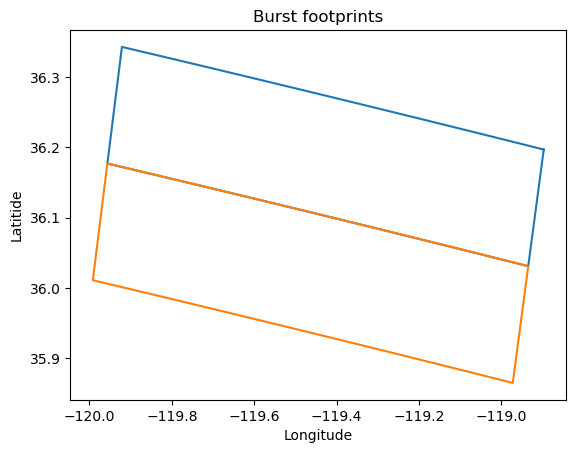

In [13]:
cslc_poly1= wkt.loads(bounding_polygon1)
cslc_poly2 = wkt.loads(bounding_polygon2)

x1,y1 = cslc_poly1.exterior.xy
x2,y2 = cslc_poly2.exterior.xy
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlabel('Longitude')
plt.ylabel('Latitide')
plt.title('Burst footprints')
plt.show()

Calculate BOI and plot.

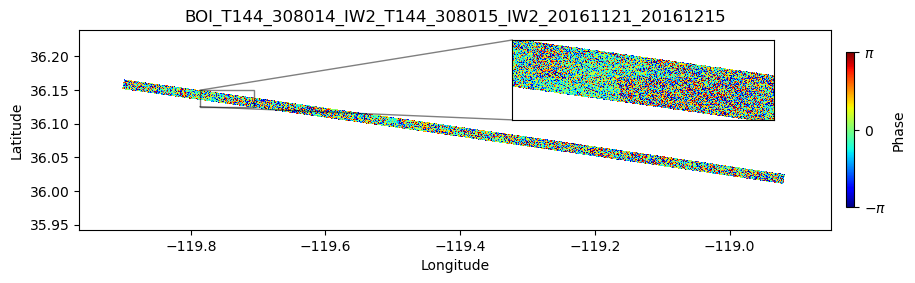

In [14]:
src = rioxarray.open_rasterio(filename1)
b1ifgtiff = src.rio.reproject("EPSG:4326")[0]
b1ifg_cpx = np.exp(1j * b1ifgtiff)
src = rioxarray.open_rasterio(filename2)
b2ifgtiff = src.rio.reproject("EPSG:4326")[0]
b2ifg_cpx = np.exp(1j * b2ifgtiff)


ifg_diff = b1ifg_cpx*np.conj(b2ifg_cpx)
phase = np.angle(ifg_diff)
phasezm = phase[1577:2009,3163:4575]

minlon,minlat,maxlon,maxlat = b1ifgtiff.rio.bounds()
bbox = [minlon,maxlon,minlat,maxlat]

# Plot BOI interferogram
fig, ax = plt.subplots(figsize=(10,3))
cax = ax.imshow(phase, cmap='jet',interpolation='nearest',extent=bbox,origin='upper', vmin=-np.pi, vmax=np.pi)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02,label='Phase')
cbar.set_ticks([-np.pi, 0., np.pi])

# inset axes
axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
axins.imshow(phase,cmap='jet',interpolation='nearest',extent=bbox,origin='upper', vmin=-np.pi, vmax=np.pi)
# subregion of the original image
x1, x2, y1, y2 = b1ifgtiff.x[3163], b1ifgtiff.x[4575],b1ifgtiff.y[2009], b1ifgtiff.y[1577]
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(left=False,bottom=False)
ax.indicate_inset_zoom(axins, edgecolor="black")
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'BOI_{burst_id[0]}_{burst_id[1]}_{dates[25]}_{dates[26]}',fontsize=12)
plt.show()